In [1]:
import numpy as np
import pandas as pd
import whois
import datetime
from os.path import splitext
import tldextract
from urllib.parse import urlparse


from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


from matplotlib import pyplot as plt

## 1. Загрузка очищенных данных

In [2]:
df = pd.read_csv('clean_min_docs.csv')

In [3]:
df

,Unnamed: 0,Unnamed: 0.1,label,url,text,len in symbols,len in words
0,0,0,0,http://arbitrsamara.ru/dogovor-arendy/obespech...,связь правило высокий стоимость имущество пере...,215,28
1,1,1,0,http://inlobnya.ru/novosti/obrazovanie/vospita...,быть правительство брать обязанность выплачива...,181,26
2,2,2,0,http://marslanov.com/otzyvy/audit-kompanii-22-...,затем потребоваться снять крупный сумма начать...,329,49
3,3,3,0,http://mail.mycompany.su/RU/dinskaya/company/m...,каждый фирма рубрика услуга микрофинансировани...,128,18
4,4,4,1,https://ok.ru/ksfirst/topic/70000727225755,минимальный пакет документ минимальный_пакет п...,29,3
...,...,...,...,...,...,...,...
1099,1099,1099,0,http://citylife-spb.ulcraft.com/,наш фирма лидер рынок свой область наш_фирма ф...,44,9
1100,1100,1100,1,https://ok.ru/avtolombards/topic/69818751358246,получение заём клиент должный предоставить мин...,147,17
1101,1101,1101,0,http://etprf.ru/NotificationEX/id/109593,поставка оборудование эквайринг предоставление...,555,63
1102,1102,1102,0,http://customsforum.ru/citizens/auto-parts/,случай непредставление соответствующий докумен...,342,34


In [4]:
df.pop("Unnamed: 0")
df.pop("Unnamed: 0.1")

0          0
1          1
2          2
3          3
4          4
        ... 
1099    1099
1100    1100
1101    1101
1102    1102
1103    1103
Name: Unnamed: 0.1, Length: 1104, dtype: int64

In [5]:
df

,label,url,text,len in symbols,len in words
0,0,http://arbitrsamara.ru/dogovor-arendy/obespech...,связь правило высокий стоимость имущество пере...,215,28
1,0,http://inlobnya.ru/novosti/obrazovanie/vospita...,быть правительство брать обязанность выплачива...,181,26
2,0,http://marslanov.com/otzyvy/audit-kompanii-22-...,затем потребоваться снять крупный сумма начать...,329,49
3,0,http://mail.mycompany.su/RU/dinskaya/company/m...,каждый фирма рубрика услуга микрофинансировани...,128,18
4,1,https://ok.ru/ksfirst/topic/70000727225755,минимальный пакет документ минимальный_пакет п...,29,3
...,...,...,...,...,...
1099,0,http://citylife-spb.ulcraft.com/,наш фирма лидер рынок свой область наш_фирма ф...,44,9
1100,1,https://ok.ru/avtolombards/topic/69818751358246,получение заём клиент должный предоставить мин...,147,17
1101,0,http://etprf.ru/NotificationEX/id/109593,поставка оборудование эквайринг предоставление...,555,63
1102,0,http://customsforum.ru/citizens/auto-parts/,случай непредставление соответствующий докумен...,342,34


## 2. Извлечение признаков из URL

In [6]:
#function to perform whois on given url
def perform_whois(url):
    try:
        whois_result = whois.whois(url)
        return whois_result
    except Exception:
        return False

In [7]:
#function to fetch the website age in days using URL created_date
def get_registered_date_in_days(whois_result):
    if(whois_result!=False):
        created_date = whois_result.creation_date
        if((created_date is not None) and (type(created_date)!=str)):
            if(type(created_date)==list):
                created_date=created_date[0]
            today_date=datetime.datetime.now()
            days = (today_date-created_date).days
            return days
        else:
            return -1
    else:
        return -1

In [8]:
def get_expiration_date_in_days(whois_result):
    if(whois_result!=False):
        expiration_date = whois_result.expiration_date
        if((expiration_date is not None) and (type(expiration_date)!=str)):
            if(type(expiration_date)==list):
                expiration_date = expiration_date[0]
            today_date=datetime.datetime.now()
            days = (expiration_date-today_date).days
            return days
        else:
            return -1
    else:
        return -1

In [9]:
def get_updated_date_in_days(whois_result):
    if(whois_result!=False):
        updated_date = whois_result.updated_date
        if((updated_date is not None) and (type(updated_date)!=str)):
            if(type(updated_date)==list):
                updated_date = updated_date[0]
            today_date=datetime.datetime.now()
            days = (today_date-updated_date).days
            return days
        else:
            return -1
    else:
        return -1

In [10]:
def get_dot_count(url):
    return url.count('.')

In [11]:
def get_url_length(url):
    return len(url)

In [12]:
def get_digit_count(url):
    return sum(c.isdigit() for c in url)

In [13]:
def get_special_char_count(url):
    count = 0
    special_characters = [';','+=','_','?','=','&','[',']']
    for each_letter in url:
        if each_letter in special_characters:
            count = count + 1
    return count


In [14]:
def get_hyphen_count(url):
    return url.count('-')


In [15]:
def get_double_slash(url):
    return url.count('//')

In [16]:
def get_single_slash(url):
    return url.count('/')

In [17]:
def get_at_the_rate(url):
    return url.count('@')

In [18]:
def get_protocol(url):
    protocol = urlparse(url)
    if(protocol.scheme == 'http'):
        return 1
    else:
        return 0

In [19]:
def get_protocol_count(url):
    http_count = url.count('http')
    https_count = url.count('https')
    http_count = http_count - https_count #correcting the miscount of https as http
    return (http_count + https_count)

In [20]:
registered_date_in_days = []
expiration_date_in_days = []
updated_date_in_days = []
dotCount = []
urlLength = []
digitCount = []
specialCharCount = []
hyphenCount = []
doubleSlashCount = []
singleSlashCount = []
atTheRateCount = []
protocol = []
protocolCount = []

In [21]:
def extract_all_features():
    counter = 0
    for url in df['url']:
        counter = counter + 1
        print(counter)
        whois_result = perform_whois(url)
        #Extracting whois features from URLs
        registered_date_in_days.append(get_registered_date_in_days(whois_result))
        expiration_date_in_days.append(get_expiration_date_in_days(whois_result))
        updated_date_in_days.append(get_updated_date_in_days(whois_result))
        #Extracting lexical features from URLs
        dotCount.append(get_dot_count(url))
        urlLength.append(get_url_length(url))
        digitCount.append(get_digit_count(url))
        specialCharCount.append(get_special_char_count(url))
        hyphenCount.append(get_hyphen_count(url))
        doubleSlashCount.append(get_double_slash(url))
        singleSlashCount.append(get_single_slash(url))
        atTheRateCount.append(get_at_the_rate(url))
        protocol.append(get_protocol(url))
        protocolCount.append(get_protocol_count(url))

In [22]:
%%time
extract_all_features()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
Error trying to connect to socket: closing socket
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
Error trying to connect to socket: closing socket
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252


In [23]:
print(f'Registered Date list length               : {len(registered_date_in_days)}')
print(f'Expiration Date list length               : {len(expiration_date_in_days)}')
print(f'Updation Date list length                 : {len(updated_date_in_days)}')
print(f'Dot Count list length                     : {len(dotCount)}')
print(f'URL Length list length                    : {len(urlLength)}')
print(f'Digit Count list length                   : {len(digitCount)}')
print(f'Special Character Count list length       : {len(specialCharCount)}')
print(f'Hyphen Count list length                  : {len(hyphenCount)}')
print(f'Double Slash Count list length            : {len(doubleSlashCount)}')
print(f'Single Slash Count list length            : {len(singleSlashCount)}')
print(f'At the Rate(@) Count list length          : {len(atTheRateCount)}')
print(f'ProtocolName Count list length            : {len(protocol)}')
print(f'Protocol Count list length                : {len(protocolCount)}')

Registered Date list length               : 1104
Expiration Date list length               : 1104
Updation Date list length                 : 1104
Dot Count list length                     : 1104
URL Length list length                    : 1104
Digit Count list length                   : 1104
Special Character Count list length       : 1104
Hyphen Count list length                  : 1104
Double Slash Count list length            : 1104
Single Slash Count list length            : 1104
At the Rate(@) Count list length          : 1104
ProtocolName Count list length            : 1104
Protocol Count list length                : 1104


In [24]:
features_df = pd.DataFrame()
features_df['whois_regDate'] = registered_date_in_days
features_df['whois_expDate'] = expiration_date_in_days
features_df['whois_updatedDate'] = updated_date_in_days
features_df["dot_count"] = dotCount
features_df["url_len"] = urlLength
features_df["digit_count"] = digitCount
features_df["special_count"] = specialCharCount
features_df["hyphen_count"] = hyphenCount
features_df["double_slash"] = doubleSlashCount
features_df["single_slash"] = singleSlashCount
features_df["at_the_rate"] = atTheRateCount
features_df["protocol"] = protocol
features_df["protocol_count"] = protocolCount

In [25]:
features_df = pd.DataFrame()
features_df['whois_regDate'] = registered_date_in_days
features_df['whois_expDate'] = expiration_date_in_days
features_df['whois_updatedDate'] = updated_date_in_days
features_df["dot_count"] = dotCount
features_df["url_len"] = urlLength
features_df["digit_count"] = digitCount
features_df["special_count"] = specialCharCount
features_df["hyphen_count"] = hyphenCount
features_df["double_slash"] = doubleSlashCount
features_df["single_slash"] = singleSlashCount
features_df["at_the_rate"] = atTheRateCount
features_df["protocol"] = protocol
features_df["protocol_count"] = protocolCount

In [26]:
features_df

,whois_regDate,whois_expDate,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,at_the_rate,protocol,protocol_count
0,815,280,-1,1,80,0,0,5,1,5,0,1,1
1,2389,167,-1,1,88,0,0,6,1,5,0,1,1
2,3372,280,96,1,57,2,0,4,1,5,0,1,1
3,2348,208,-1,2,53,0,0,0,1,6,0,1,1
4,8230,198,-1,1,42,14,0,0,1,5,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,2350,206,213,2,32,0,0,1,1,3,0,1,1
1100,8230,198,-1,1,47,14,0,0,1,5,0,0,1
1101,3596,56,-1,1,40,6,0,0,1,5,0,1,1
1102,2496,60,-1,1,43,0,0,1,1,5,0,1,1


In [27]:
features_df.head(10)

,whois_regDate,whois_expDate,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,at_the_rate,protocol,protocol_count
0,815,280,-1,1,80,0,0,5,1,5,0,1,1
1,2389,167,-1,1,88,0,0,6,1,5,0,1,1
2,3372,280,96,1,57,2,0,4,1,5,0,1,1
3,2348,208,-1,2,53,0,0,0,1,6,0,1,1
4,8230,198,-1,1,42,14,0,0,1,5,0,0,1
5,6190,2209,1171,1,35,1,0,0,1,4,0,0,1
6,6374,565,93,3,108,0,2,6,1,3,0,1,1
7,4524,223,-1,1,46,0,0,1,1,5,0,1,1
8,3015,271,-1,1,39,0,0,1,1,4,0,0,1
9,2272,284,-1,1,17,0,0,0,1,3,0,1,1


In [28]:
features_df.tail(10)

,whois_regDate,whois_expDate,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,at_the_rate,protocol,protocol_count
1094,8230,198,-1,1,50,18,0,0,1,5,0,0,1
1095,1655,170,-1,1,21,0,0,1,1,3,0,1,1
1096,1487,338,-1,1,20,0,0,0,1,2,0,1,1
1097,8230,198,-1,1,43,15,0,0,1,5,0,0,1
1098,8230,198,-1,1,57,29,0,0,2,7,0,0,1
1099,2350,206,213,2,32,0,0,1,1,3,0,1,1
1100,8230,198,-1,1,47,14,0,0,1,5,0,0,1
1101,3596,56,-1,1,40,6,0,0,1,5,0,1,1
1102,2496,60,-1,1,43,0,0,1,1,5,0,1,1
1103,1273,187,-1,1,32,5,0,0,1,5,0,0,1


In [29]:
features_df.shape

(1104, 13)

In [30]:
features_df.pop("at_the_rate")

0       0
1       0
2       0
3       0
4       0
       ..
1099    0
1100    0
1101    0
1102    0
1103    0
Name: at_the_rate, Length: 1104, dtype: int64

In [31]:
features_df

,whois_regDate,whois_expDate,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,protocol,protocol_count
0,815,280,-1,1,80,0,0,5,1,5,1,1
1,2389,167,-1,1,88,0,0,6,1,5,1,1
2,3372,280,96,1,57,2,0,4,1,5,1,1
3,2348,208,-1,2,53,0,0,0,1,6,1,1
4,8230,198,-1,1,42,14,0,0,1,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1099,2350,206,213,2,32,0,0,1,1,3,1,1
1100,8230,198,-1,1,47,14,0,0,1,5,0,1
1101,3596,56,-1,1,40,6,0,0,1,5,1,1
1102,2496,60,-1,1,43,0,0,1,1,5,1,1


In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(-1,1))
url_features_norm = scaler.fit_transform(features_df)

In [33]:
url_features_norm

array([[-0.8397014 , -0.78920681, -1.        , ..., -0.66666667,
         1.        , -1.        ],
       [-0.53049799, -0.87106121, -1.        , ..., -0.66666667,
         1.        , -1.        ],
       [-0.33739318, -0.78920681, -0.83447099, ..., -0.66666667,
         1.        , -1.        ],
       ...,
       [-0.29338965, -0.95146686, -1.        , ..., -0.66666667,
         1.        , -1.        ],
       [-0.50947844, -0.94856936, -1.        , ..., -0.66666667,
         1.        , -1.        ],
       [-0.74972989, -0.85657371, -1.        , ..., -0.66666667,
        -1.        , -1.        ]])

In [34]:
features_df.to_csv("additional_features.csv",index=False)

In [35]:
url_features_norm_df = pd.DataFrame(url_features_norm, columns=features_df.columns)

In [36]:
url_features_norm_df

,whois_regDate,whois_expDate,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,protocol,protocol_count
0,-0.839701,-0.789207,-1.000000,-1.0,-0.790660,-1.000000,-1.0,-0.655172,-1.0,-0.666667,1.0,-1.0
1,-0.530498,-0.871061,-1.000000,-1.0,-0.764895,-1.000000,-1.0,-0.586207,-1.0,-0.666667,1.0,-1.0
2,-0.337393,-0.789207,-0.834471,-1.0,-0.864734,-0.984252,-1.0,-0.724138,-1.0,-0.666667,1.0,-1.0
3,-0.538552,-0.841362,-1.000000,-0.6,-0.877617,-1.000000,-1.0,-1.000000,-1.0,-0.555556,1.0,-1.0
4,0.616934,-0.848606,-1.000000,-1.0,-0.913043,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1099,-0.538159,-0.842811,-0.634812,-0.6,-0.945250,-1.000000,-1.0,-0.931034,-1.0,-0.888889,1.0,-1.0
1100,0.616934,-0.848606,-1.000000,-1.0,-0.896940,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
1101,-0.293390,-0.951467,-1.000000,-1.0,-0.919485,-0.952756,-1.0,-1.000000,-1.0,-0.666667,1.0,-1.0
1102,-0.509478,-0.948569,-1.000000,-1.0,-0.909823,-1.000000,-1.0,-0.931034,-1.0,-0.666667,1.0,-1.0


In [37]:
url_features_norm_df.to_csv("additional_features_norm.csv",index=False)

## 3. Классификация только на признаках URL

### 3.1. Данные для обучения

In [6]:
url_features_norm_df = pd.read_csv('additional_features_norm.csv')

In [7]:
X = url_features_norm_df
y = df['label']

In [8]:
X

,whois_regDate,whois_expDate,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,protocol,protocol_count
0,-0.839701,-0.789207,-1.000000,-1.0,-0.790660,-1.000000,-1.0,-0.655172,-1.0,-0.666667,1.0,-1.0
1,-0.530498,-0.871061,-1.000000,-1.0,-0.764895,-1.000000,-1.0,-0.586207,-1.0,-0.666667,1.0,-1.0
2,-0.337393,-0.789207,-0.834471,-1.0,-0.864734,-0.984252,-1.0,-0.724138,-1.0,-0.666667,1.0,-1.0
3,-0.538552,-0.841362,-1.000000,-0.6,-0.877617,-1.000000,-1.0,-1.000000,-1.0,-0.555556,1.0,-1.0
4,0.616934,-0.848606,-1.000000,-1.0,-0.913043,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1099,-0.538159,-0.842811,-0.634812,-0.6,-0.945250,-1.000000,-1.0,-0.931034,-1.0,-0.888889,1.0,-1.0
1100,0.616934,-0.848606,-1.000000,-1.0,-0.896940,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
1101,-0.293390,-0.951467,-1.000000,-1.0,-0.919485,-0.952756,-1.0,-1.000000,-1.0,-0.666667,1.0,-1.0
1102,-0.509478,-0.948569,-1.000000,-1.0,-0.909823,-1.000000,-1.0,-0.931034,-1.0,-0.666667,1.0,-1.0


In [9]:
y

0       0
1       0
2       0
3       0
4       1
       ..
1099    0
1100    1
1101    0
1102    0
1103    1
Name: label, Length: 1104, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)


In [11]:
from sklearn.model_selection import RepeatedStratifiedKFold

### 3.2. Подбор параметров и классификация

In [12]:
%%time 
param_grid =[{'kernel': ['linear'], 
               'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
             
             {'kernel': ['rbf'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001]}, 
            ]

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = RepeatedStratifiedKFold(10,3), n_jobs=-1, return_train_score=True, scoring='f1')
grid.fit(X_train, y_train)

Fitting 30 folds for each of 49 candidates, totalling 1470 fits


/Users/anastasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_splits=10, n_repeats=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 309 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   25.8s


CPU times: user 1.22 s, sys: 159 ms, total: 1.37 s
Wall time: 41.4 s


[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed:   41.4s finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='f1', verbose=3)

In [13]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 0.001, 'kernel': 'linear'}
SVC(C=0.001, kernel='linear')


In [29]:
results = pd.DataFrame(grid.cv_results_)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
0,0.021151,0.002770,0.004914,0.000790,0.001,linear,NaN,"{'C': 0.001, 'kernel': 'linear'}",0.891892,0.935065,...,0.934097,0.934097,0.934097,0.932374,0.933908,0.938484,0.934097,0.931034,0.934188,0.00264
1,0.007413,0.000584,0.003697,0.000476,0.01,linear,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.891892,0.935065,...,0.934097,0.934097,0.934097,0.932374,0.933908,0.938484,0.934097,0.931034,0.934188,0.00264
2,0.006334,0.001353,0.003893,0.001306,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.891892,0.935065,...,0.934097,0.934097,0.934097,0.932374,0.933908,0.938484,0.934097,0.931034,0.934188,0.00264
3,0.007533,0.002079,0.004030,0.001051,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.891892,0.935065,...,0.934097,0.934097,0.934097,0.932374,0.933908,0.938484,0.934097,0.931034,0.934188,0.00264
4,0.007673,0.000716,0.003452,0.000626,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.891892,0.935065,...,0.934097,0.934097,0.934097,0.932374,0.933908,0.938484,0.934097,0.931034,0.934188,0.00264
5,1.041544,0.468683,0.003164,0.000085,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.891892,0.935065,...,0.934097,0.934097,0.934097,0.932374,0.933908,0.938484,0.934097,0.931034,0.934188,0.00264
6,4.963434,1.746397,0.002700,0.000560,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.891892,0.935065,...,0.934097,0.934097,0.934097,0.932374,0.933908,0.938484,0.934097,0.931034,0.934188,0.00264
7,0.024941,0.001451,0.004716,0.000388,0.001,rbf,10,"{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
8,0.024276,0.001225,0.004601,0.000134,0.001,rbf,1,"{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
9,0.024261,0.000695,0.004618,0.000078,0.001,rbf,0.1,"{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [27]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(grid.best_estimator_, X, y, "C",[0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=10)

/Users/anastasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass param_name=C, param_range=[0.001, 0.01, 0.1, 1, 10, 100, 1000] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


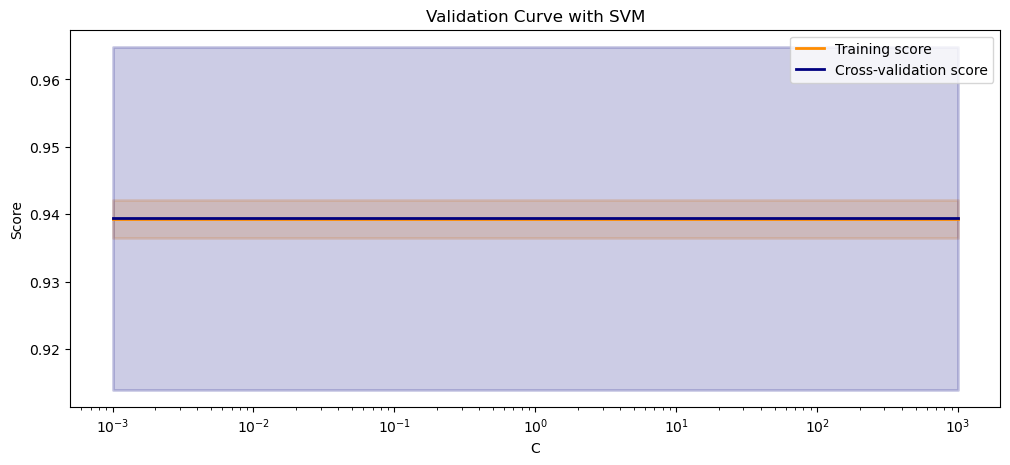

<Figure size 432x288 with 0 Axes>

In [28]:
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


fig = plt.figure(figsize=(12, 5), dpi=100)
plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()
plt.savefig("url_valid_curve.png")


In [30]:
scores_rbf = np.array(results[results.param_kernel=='rbf'].mean_test_score).reshape(7,6)

In [31]:
scores_rbf

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.29677287, 0.92470334, 0.93371231, 0.        , 0.        ,
        0.        ],
       [0.84129995, 0.93135276, 0.93371231, 0.93371231, 0.        ,
        0.        ],
       [0.92254186, 0.93252665, 0.93371231, 0.93371231, 0.93371231,
        0.        ],
       [0.91387765, 0.93227552, 0.93371231, 0.93371231, 0.93371231,
        0.93371231],
       [0.8932336 , 0.92735347, 0.93371231, 0.93371231, 0.93371231,
        0.93371231],
       [0.87972344, 0.91027691, 0.93285477, 0.93371231, 0.93371231,
        0.93371231]])

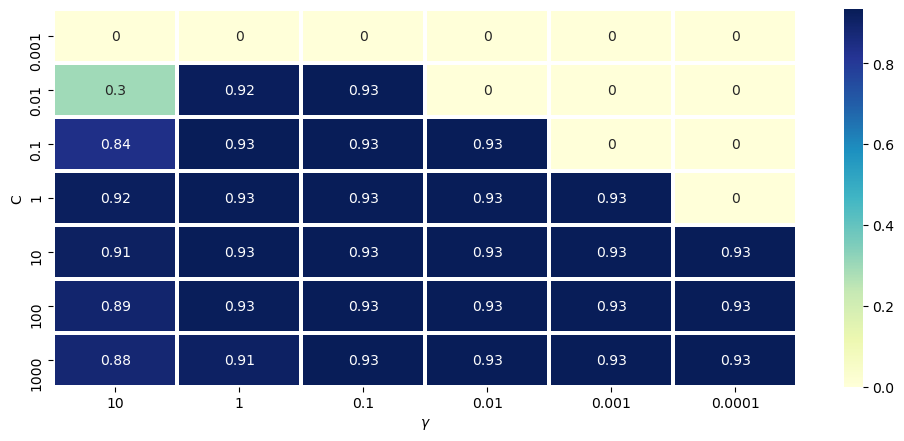

In [32]:
import seaborn as sns 

x1 = 10, 1, 0.1, 0.01, 0.001, 0.0001
y1 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
fig = plt.figure(figsize=(12, 5), dpi=100)
sns.heatmap(scores_rbf, cmap="YlGnBu", annot=True, linewidths=2, xticklabels=x1, yticklabels=y1)
plt.xlabel("$\gamma$")
plt.ylabel("C")
plt.savefig("url_heatmap_rbf.png")


In [22]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test, grid_predictions))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       135
           1       1.00      0.89      0.94       141

    accuracy                           0.94       276
   macro avg       0.95      0.94      0.94       276
weighted avg       0.95      0.94      0.94       276



In [23]:
print ('Accuracy (test) =', metrics.accuracy_score(y_test, grid_predictions))
print ('Precision(test) =', metrics.precision_score(y_test, grid_predictions))
print ('Recall(test) =', metrics.recall_score(y_test, grid_predictions))
print ('F1-score (test) =', metrics.f1_score(y_test, grid_predictions))


Accuracy (test) = 0.9420289855072463
Precision(test) = 1.0
Recall(test) = 0.8865248226950354
F1-score (test) = 0.9398496240601504


In [15]:
clf = grid.best_estimator_

In [16]:
pred_train = clf.predict(X_train)
print ('Accuracy (train)=', metrics.accuracy_score(y_train, pred_train))
print ('Precision(train) =', metrics.precision_score(y_train, pred_train))
print ('Recall (train)=', metrics.recall_score(y_train, pred_train))
print ('F1-score (train) =', metrics.f1_score(y_train, pred_train))

Accuracy (train)= 0.9384057971014492
Precision(train) = 1.0
Recall (train)= 0.8765133171912833
F1-score (train) = 0.9341935483870968


In [17]:
scores_acc = cross_val_score(clf, X, y, cv=10, scoring = 'accuracy')
scores_pre = cross_val_score(clf, X, y, cv=10, scoring = 'precision')
scores_re  = cross_val_score(clf, X, y, cv=10, scoring = 'recall')
scores_f1 = cross_val_score(clf, X, y, cv=10, scoring = 'f1')


In [18]:
print('Accuracy')
print(scores_acc)
print(np.mean(scores_acc))

print('Precision')
print(scores_pre)
print(np.mean(scores_pre))


print('Recall')
print(scores_re)
print(np.mean(scores_re))

print('F1')
print(scores_f1)
print(np.mean(scores_f1))

Accuracy
[0.90990991 0.92792793 0.95495495 0.89189189 0.97272727 0.95454545
 0.94545455 0.97272727 0.91818182 0.94545455]
0.9393775593775594
Precision
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0
Recall
[0.82142857 0.85714286 0.91071429 0.78571429 0.94545455 0.90909091
 0.89090909 0.94545455 0.83636364 0.89090909]
0.8793181818181818
F1
[0.90196078 0.92307692 0.95327103 0.88       0.97196262 0.95238095
 0.94230769 0.97196262 0.91089109 0.94230769]
0.9350121395178137


In [19]:
#сохранение полученного классификатора 
import joblib

joblib.dump(grid, 'url_features_SVM.pkl')


['url_features_SVM.pkl']

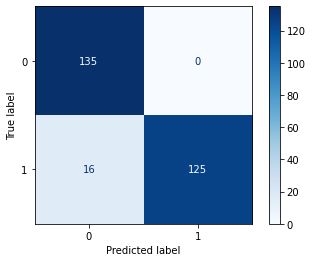

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, grid_predictions)

cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.savefig('url_svm_conf_matrix.png')

In [50]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

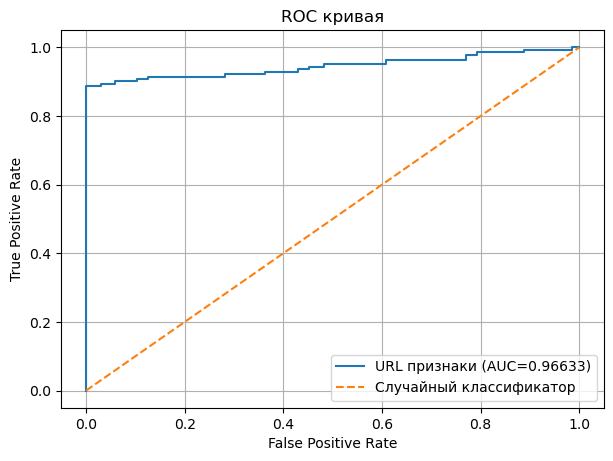

In [53]:

fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

fpr, tpr, _ = roc_curve(y_test, clf.decision_function(X_test))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name='URL признаки (AUC={0:0.5f})'.format(average_precision_score(y_test, clf.decision_function(X_test))))
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайный классификатор')
plt.legend()
plt.title("ROC кривая")
plt.grid()
plt.savefig('url_roc_curve.png')


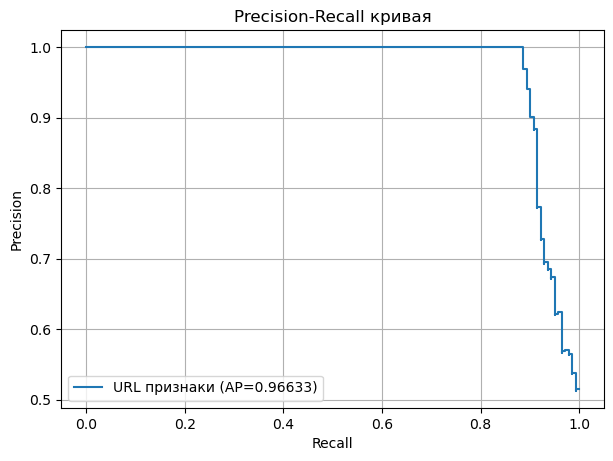

In [54]:

fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

prec, recall, _ = precision_recall_curve(y_test, clf.decision_function(X_test))
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax, name='URL признаки (AP={0:0.5f})'.format(average_precision_score(y_test, clf.decision_function(X_test))))

plt.title("Precision-Recall кривая")
plt.grid();
plt.savefig('url_pr_curve.png')

Text(0.5, 1.0, 'Тепловая карта корреляции признаков')

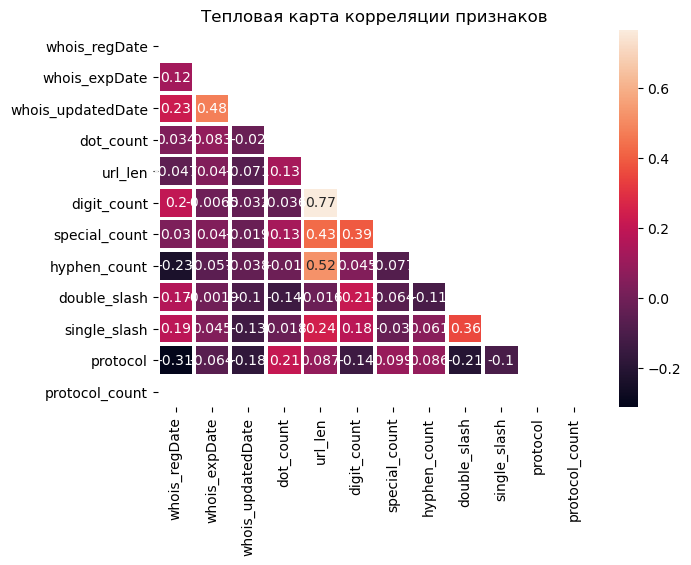

In [104]:
fig = plt.figure(figsize=(7, 5), dpi=100)
corrMatrix = X.corr()
matrix = np.triu(corrMatrix)
sns.heatmap(corrMatrix, annot=True, mask=matrix,linewidths=2)
plt.title("Тепловая карта корреляции признаков")
#plt.savefig('url_pr_curve.png')

In [43]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, grid_predictions)

0.8902743496480492

## 4. Визулизация

In [63]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
text_vectors_matrix_2d = tsne.fit_transform(X)
print("text_vectors_matrix_2d shape is ", text_vectors_matrix_2d.shape)

text_vectors_matrix_2d shape is  (1104, 2)


In [64]:
points_text = pd.DataFrame({'text':df['text'], 'x':text_vectors_matrix_2d[:,0], 'y':text_vectors_matrix_2d[:,1]} )

In [65]:
points_text

,text,x,y
0,связь правило высокий стоимость имущество пере...,13.546865,5.006340
1,быть правительство брать обязанность выплачива...,14.961206,9.346341
2,затем потребоваться снять крупный сумма начать...,15.970493,13.077995
3,каждый фирма рубрика услуга микрофинансировани...,-4.327357,21.454647
4,минимальный пакет документ минимальный_пакет п...,-25.343134,-33.570053
...,...,...,...
1099,наш фирма лидер рынок свой область наш_фирма ф...,-0.451360,19.180445
1100,получение заём клиент должный предоставить мин...,-30.975893,-34.776737
1101,поставка оборудование эквайринг предоставление...,24.550056,12.401879
1102,случай непредставление соответствующий докумен...,21.291769,9.352834


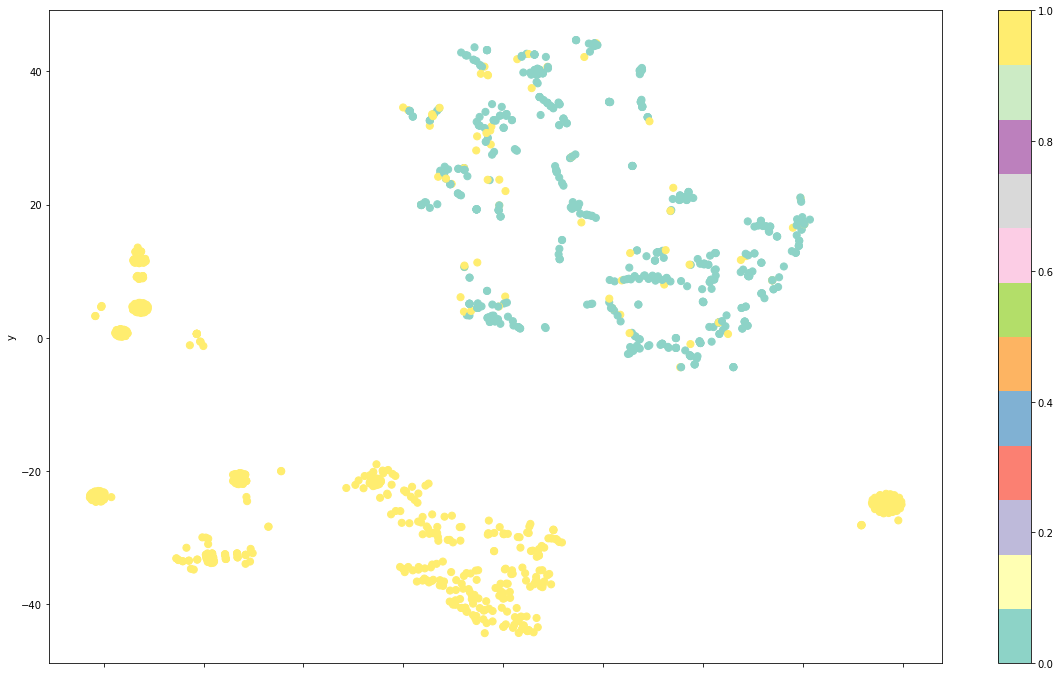

In [66]:
points_text.plot.scatter("x", "y", s=50, figsize=(20, 12), c=df['label'], colormap='Set3')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('URL_vectors_full_texts.png');
